In [1]:
windows = 10
seed = 2023

In [2]:
import pandas as pd
import numpy as np
ground = pd.read_csv('./data/sh.000001.csv')

ground_date = pd.to_datetime(ground['date'])
dates = ground_date.tolist()
# sh300
sh300 = pd.read_csv('hs300_stocks.csv')
stock_list = sh300.code.tolist()

def df_tolist(df):
    # 将pandas.dataframe转list
    array_ = np.array(df)
    list_ = array_.tolist()
    return list_

features = []
labels = []
for stock in stock_list:
    df = pd.read_csv('./data/%s.csv' % stock)
    df['date'] = pd.to_datetime(df['date'])
    data_ = pd.merge(ground_date, df, how='left', on='date')
    data_ = data_.iloc[:,1:].dropna(how='any')
    data_.pctChg = data_.pctChg/100

    for idx in range(len(data_)-windows):
        if np.all(data_.iloc[idx:idx+windows+1,:]) != 0: 
            
            feature = data_.iloc[idx:idx+windows,1:]
            label = data_.iloc[idx+windows,6]
            
            feature = df_tolist(feature)
            
            
            features.append(feature)
            
            labels.append(label)

features = np.array(features)
labels = np.array(labels)
print(labels.shape)
print(features.shape)





(26504,)
(26504, 10, 7)


In [3]:
max_value = ground.iloc[:,2:].max().values
max_value.shape

(7,)

In [4]:
np.random.seed(seed=seed)
np.random.shuffle(features)
np.random.shuffle(labels)

features = features/max_value
labels = labels/max_value[6]

In [5]:
print(features.shape)
print(labels.shape)

(26504, 10, 7)
(26504,)


In [6]:
# 定义划分比例
train_ratio = 0.8

# 计算划分的索引
split_index = int(features.shape[0] * train_ratio)

# 划分数据集
x_train, x_test = features[:split_index], features[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# 打印训练集和测试集的形状
print("训练集形状:", x_train.shape, y_train.shape)
print("测试集形状:", x_test.shape, y_test.shape)

训练集形状: (21203, 10, 7) (21203,)
测试集形状: (5301, 10, 7) (5301,)


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(None,7)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# 创建TensorBoard回调函数
tensorboard_callback = TensorBoard(log_dir='./lstm_log', histogram_freq=1)

# 创建EarlyStopping回调函数
earlystop_callback = EarlyStopping(monitor='val_loss', patience=3)

# 创建ModelCheckpoint回调函数
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      mode='min', 
                                      period=5)



Epoch 1/25


2023-07-30 13:35:11.854406: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


332/332 [==============================] - 6s 14ms/step - loss: 2.5072
Epoch 2/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4585
Epoch 3/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4435
Epoch 4/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4417
Epoch 5/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4423
Epoch 6/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4400
Epoch 7/25
332/332 [==============================] - 4s 13ms/step - loss: 2.4389
Epoch 8/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4383
Epoch 9/25
332/332 [==============================] - 4s 13ms/step - loss: 2.4323
Epoch 10/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4255
Epoch 11/25
332/332 [==============================] - 5s 14ms/step - loss: 2.4306
Epoch 12/25
332/332 [==============================] - 4s 13ms/step - loss: 2.4286
Epoch 13/25
332/332 [===

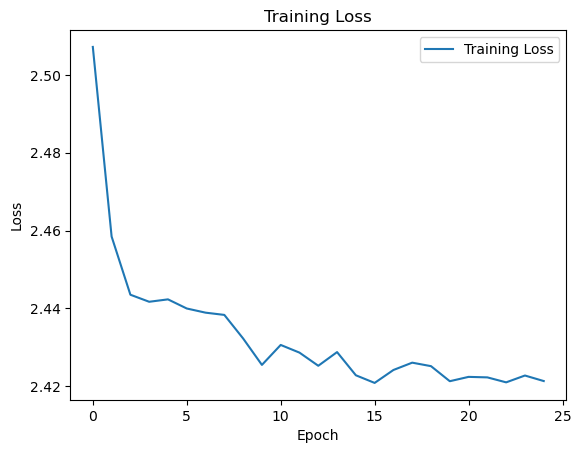

In [9]:
import matplotlib.pyplot as plt

# 训练模型并获取History对象
history = model.fit(x_train, y_train, epochs=25, batch_size=64, callbacks=[tensorboard_callback, checkpoint_callback, earlystop_callback])

# 获取训练损失值
loss = history.history['loss']

# 创建一个图形
plt.figure()

# 绘制损失曲线
plt.plot(loss, label='Training Loss')

# 添加标题和标签
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 显示图形
plt.show()